In [2]:
from pathlib import Path
from collections import defaultdict
from typing import Iterator
from PIL import Image
import PIL
import numpy as np
import os, sys
import json
import hdf5storage


In [3]:
## Internal dependencies

sys.path.append(os.path.dirname(os.getcwd()))
sys.path.append(os.path.join(os.path.dirname(os.getcwd()), 'src'))
sys.path.append(os.path.join(os.path.dirname(os.getcwd()), 'utils'))

from utils.data_structs import ColumnStruct

## Data

In [2]:
# SOURCE DATA

dataset_path = Path('../datasets/raw/HELEN')             # Example
test_path = dataset_path / 'test'
train_path = dataset_path / 'train'

print(f'{os.path.basename(dataset_path)} test path {"exists" if test_path.exists() else "does not exist"}')
print(f'{os.path.basename(dataset_path)} train path {"exists" if train_path.exists() else "does not exist"}')

print(f'{os.path.basename(dataset_path)} test set contains {len(os.listdir(test_path))} images')
print(f'{os.path.basename(dataset_path)} train set contains {len(os.listdir(train_path))} images')

HELEN test path exists
HELEN train path exists
HELEN test set contains 330 images
HELEN train set contains 2000 images


In [3]:
# DESTINATION DATA

dest_dataset_path = Path('../datasets/processed') / Path(os.path.basename(dataset_path))
dest_test_path = dest_dataset_path / 'test'
dest_train_path = dest_dataset_path / 'train'

if not dest_dataset_path.exists():
    dest_dataset_path.mkdir()

if not dest_test_path.exists():
    dest_test_path.mkdir()

if not dest_train_path.exists():
    dest_train_path.mkdir()

In [4]:
import shutil

shutil.copy('../extras/test/see_bboxes.m', str(dest_test_path/'see_bboxes.m'))
shutil.copy('../extras/train/see_bboxes.m', str(dest_train_path/'see_bboxes.m'))

'..\\datasets\\processed\\HELEN\\train\\see_bboxes.m'

## Annotations

In [7]:
data_dict = defaultdict(str)

annotation_path = dataset_path / "annotation" / "annotation"
print(f'HELEN annotation path {"exists" if annotation_path.exists() else "does not exist"}')

test_image_names = [Path(file.strip('\n')).stem for file in os.listdir(test_path)]
train_image_names = [Path(file.strip('\n')).stem for file in os.listdir(train_path)]

test_annotations = []
train_annotations = []

for txt_file in os.listdir(annotation_path):
    with open (annotation_path / txt_file, 'r') as annotation_txt:
        lines = annotation_txt.readlines()
        img_name = lines.pop(0).strip('\n')

        if img_name in test_image_names:
            # print(f"{img_name} in test images")
            test_annotations.append(img_name)

        if img_name in train_image_names:
            # print(f"{img_name} in train images")
            train_annotations.append(img_name)

        data_dict[img_name] = []
        for coord in lines:
            x, y = tuple(coord.rstrip('\n').split(','))
            data_dict[img_name].append((float(x), float(y)))

print(f'{os.path.basename(dataset_path)} test images are {"100%" if len(test_image_names) == len(test_annotations) else "<100%"} annotated')
print(f'{os.path.basename(dataset_path)} train images are {"100%" if len(train_image_names) == len(train_annotations) else "<100%"} annotated')

out_file = open('annotations.json', 'w')
json.dump(data_dict, out_file, indent=4)


HELEN annotation path exists
HELEN test images are 100% annotated
HELEN train images are 100% annotated


## Image analysis

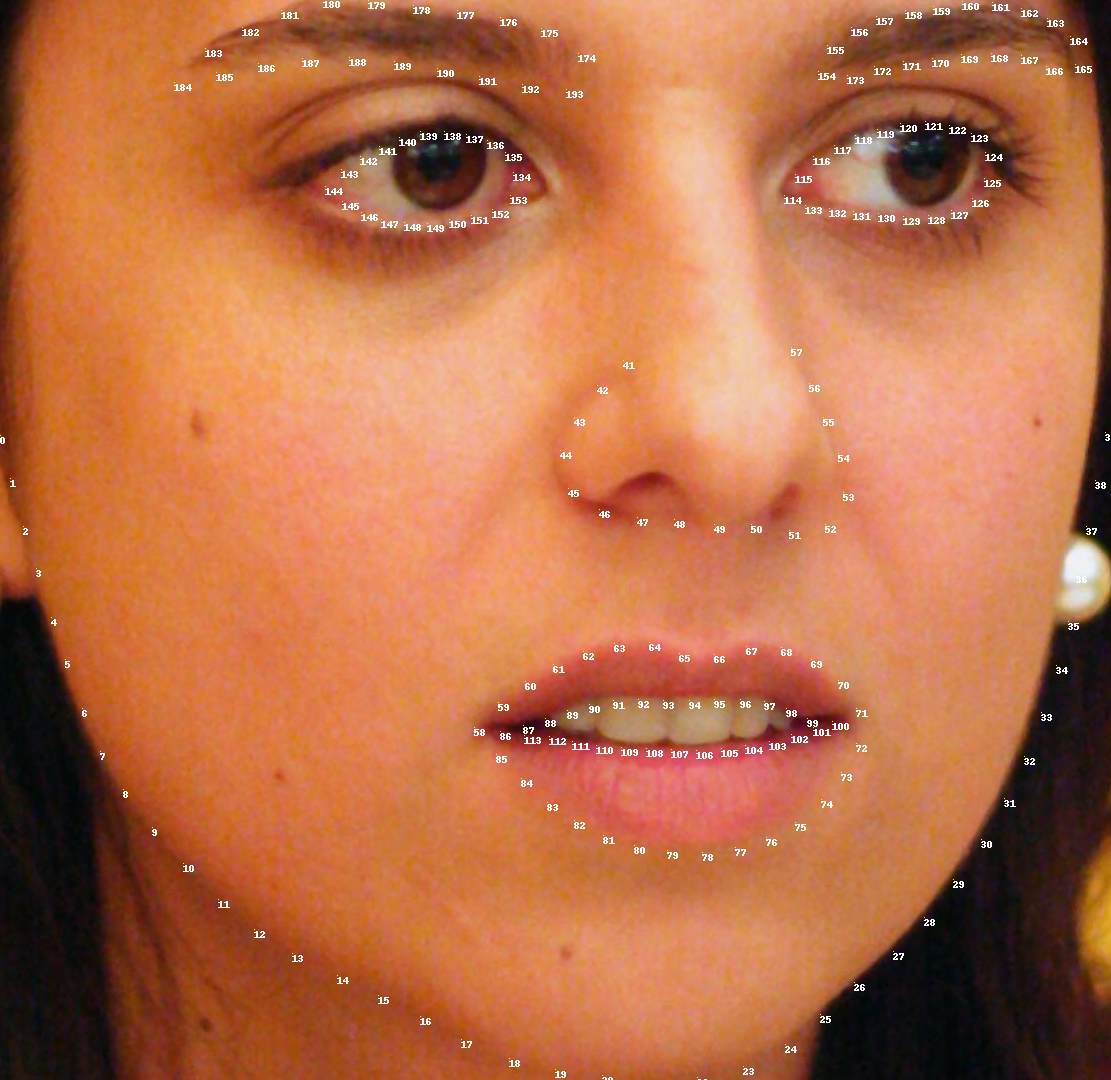

In [8]:
from PIL import Image, ImageDraw
import numpy as np

with open ('annotations.json', 'r') as annotation_file:
    annotations = json.load(annotation_file)

first_image_name = test_image_names[3]

img = Image.open(test_path / (first_image_name + ".jpg"))
draw = ImageDraw.Draw(img)

w, h = img.size

for i, annotation in enumerate(annotations[first_image_name]):
    draw.point(tuple(annotation), fill="yellow")
    draw.text(tuple(annotation), text=str(i))

label_arr = np.array(annotations[first_image_name])

left = np.min(label_arr[:,0])
right = np.max(label_arr[:,0])
top = np.min(label_arr[:,1])
bottom = np.max(label_arr[:,1])

cropped_img = img.crop((left, top, right, bottom))
cropped_img

## Combine Data sources (HELEN and LFPW)

In [10]:
from pathlib import Path

# SOURCE DATA

helen_dataset_path = Path('../datasets/raw/HELEN')             # Example
helen_test_path = helen_dataset_path / 'test'
helen_train_path = helen_dataset_path / 'train'

print(f'{os.path.basename(helen_dataset_path)} test path {"exists" if helen_test_path.exists() else "does not exist"}')
print(f'{os.path.basename(helen_dataset_path)} train path {"exists" if helen_train_path.exists() else "does not exist"}')

print(f'{os.path.basename(helen_dataset_path)} test set contains {len(os.listdir(helen_test_path))} images')
print(f'{os.path.basename(helen_dataset_path)} train set contains {len(os.listdir(helen_train_path))} images')

lfpw_dataset_path = Path('../datasets/raw/lfpw-labelled-face-parts-in-the-wild/')             # Example
lfpw_test_path = lfpw_dataset_path / 'testset'
lfpw_train_path = lfpw_dataset_path / 'trainset'

print(f'{os.path.basename(lfpw_dataset_path)} test path {"exists" if lfpw_test_path.exists() else "does not exist"}')
print(f'{os.path.basename(lfpw_dataset_path)} train path {"exists" if lfpw_train_path.exists() else "does not exist"}')

print(f'{os.path.basename(lfpw_dataset_path)} test set contains {len(os.listdir(lfpw_test_path))} images')
print(f'{os.path.basename(lfpw_dataset_path)} train set contains {len(os.listdir(lfpw_train_path))} images')

HELEN test path exists
HELEN train path exists
HELEN test set contains 330 images
HELEN train set contains 2000 images
lfpw-labelled-face-parts-in-the-wild test path exists
lfpw-labelled-face-parts-in-the-wild train path exists
lfpw-labelled-face-parts-in-the-wild test set contains 448 images
lfpw-labelled-face-parts-in-the-wild train set contains 1622 images


In [11]:
# DESTINATION DATA
dest_dataset_path = Path('../datasets/processed/COMBINED/')
dest_test_path = dest_dataset_path / 'test'
dest_train_path = dest_dataset_path / 'train'

if not dest_dataset_path.is_dir():
    dest_dataset_path.mkdir()

if not dest_test_path.exists():
    dest_test_path.mkdir()

if not dest_train_path.exists():
    dest_train_path.mkdir()

In [12]:
import shutil

shutil.copy('../extras/test/see_bboxes.m', str(dest_test_path/'see_bboxes.m'))
shutil.copy('../extras/train/see_bboxes.m', str(dest_train_path/'see_bboxes.m'))

'..\\datasets\\processed\\COMBINED\\train\\see_bboxes.m'

In [13]:
combined_container = []
index = 1

# HELEN

## Squish dataset (50%)

In [14]:
face_img = None
left_eye_img = None
right_eye_img = None
nose_img = None
lips_img = None

symmetrical_scale = 0.5

scale_width = symmetrical_scale
scale_height = symmetrical_scale

left_offset = 10
top_offset = 10
right_offset = 10
bottom_offset = 10

count = 0

tset_paths = [train_path, test_path]
tsets = ['train', 'test']

tset_path = tset_paths[index]
tset = tsets[index]

it = iter(sorted(os.listdir(tset_path)))

for data in it:
    img = data
    img_path = tset_path / img

    full_pts = np.array(annotations[img_path.stem])
    full_img = Image.open(img_path)

    left_of_face = np.min(full_pts[:,0])
    right_of_face = np.max(full_pts[:,0])
    top_of_face = np.min(full_pts[:,1])
    bottom_of_face = np.max(full_pts[:,1])

    face_img = full_img.crop((left_of_face, top_of_face, right_of_face, bottom_of_face))
    face_img = face_img.resize((int(face_img.width*scale_width), int(face_img.height*scale_height)))

    left_eye_img = face_img.crop(
        (
            int((full_pts[144][0] - left_of_face)*scale_width) - left_offset,
            int((full_pts[138][1] - top_of_face)*scale_height) - top_offset,
            int((full_pts[134][0] - left_of_face)*scale_width) + right_offset,
            int((full_pts[149][1] - top_of_face)*scale_height) + bottom_offset
        )
    )

    right_eye_img = face_img.crop(
        (
            int((full_pts[114][0] - left_of_face)*scale_width) - left_offset,
            int((full_pts[120][1] - top_of_face)*scale_height) - top_offset,
            int((full_pts[124][0] - left_of_face)*scale_width) + right_offset,
            int((full_pts[129][1] - top_of_face)*scale_height) + bottom_offset
        )
    )

    # nose_img = face_img.crop(
    #     (
    #         int(full_pts[44][0]) - left_of_face - 20,
    #         int(full_pts[57][1]) - top_of_face - 20,
    #         int(full_pts[53][0]) - left_of_face + 20,
    #         int(full_pts[49][1]) - top_of_face + 20
    #     )
    # )

    # lips_img = face_img.crop(
    #     (
    #         int(full_pts[58][0]) - left_of_face - 20,
    #         int(full_pts[67][1]) - top_of_face - 20,
    #         int(full_pts[71][0]) - left_of_face + 20,
    #         int(full_pts[78][1]) - top_of_face + 20
    #     )
    # )

    left_eye_left = int((full_pts[144][0] - left_of_face)*scale_width) - left_offset
    left_eye_top = int((full_pts[138][1] - top_of_face)*scale_height) - top_offset
    left_eye_right = int((full_pts[134][0] - left_of_face)*scale_width) + right_offset
    left_eye_bottom = int((full_pts[149][1] - top_of_face)*scale_height) + bottom_offset

    if left_eye_left < 0:
        left_eye_left = 0
    
    if left_eye_top < 0:
        left_eye_top = 0
    
    right_eye_left = int((full_pts[114][0] - left_of_face)*scale_width) - left_offset
    right_eye_top = int((full_pts[120][1] - top_of_face)*scale_height) - top_offset
    right_eye_right = int((full_pts[124][0] - left_of_face)*scale_width) + right_offset
    right_eye_bottom = int((full_pts[129][1] - top_of_face)*scale_height) + bottom_offset

    if right_eye_top < 0:
        right_eye_top = 0

    if right_eye_right >= (face_img.width):
        right_eye_right = face_img.width - 1

    nose_left = int(full_pts[44][0] - left_of_face - left_offset)
    nose_top = int(full_pts[57][1] - top_of_face - top_offset)
    nose_right = int(full_pts[53][0] - left_of_face + right_offset)
    nose_bottom = int(full_pts[49][1] - top_of_face + bottom_offset)

    lips_left = int(full_pts[58][0] - left_of_face - left_offset)
    lips_top = int(full_pts[67][1] - top_of_face - top_offset)
    lips_right = int(full_pts[71][0] - left_of_face + right_offset)
    lips_bottom = int(full_pts[78][1] - top_of_face + bottom_offset)

    if lips_bottom > face_img.height:
        lips_bottom = face_img.height - 1

    left_eye_bbox = [
        left_eye_right - left_eye_left,  # height
        left_eye_left,                         # left
        left_eye_top,                           # top
        left_eye_bottom - left_eye_top   # width
    ]

    right_eye_bbox = [
        right_eye_right - right_eye_left,  # height
        right_eye_left,                         # left
        right_eye_top,                           # top
        right_eye_bottom - right_eye_top   # width
    ]

    nose_bbox = [
        nose_right - nose_left,
        nose_left,
        nose_top,
        nose_bottom - nose_top
    ]

    lips_bbox = [
        lips_right - lips_left,
        lips_left,
        lips_top,
        lips_bottom - lips_top
    ]

    struct = ColumnStruct (filename=img, header=("filename", "height", "left", "top", "width", "label"), label_by_index=True)
    struct.add(left_eye_bbox, 0)
    struct.add(right_eye_bbox, 1)
    # struct.add(nose_bbox, 2)
    # struct.add(lips_bbox, 3)

    combined_container.append(struct.entry())

    face_img.save(dest_dataset_path / tset / img)

    # break


# left_eye_img
# right_eye_img
# lips_img
# nose_img

C:\Users\MTinaco\AppData\Local\Temp\ipykernel_29012\1523098808.py:11: DeprecationWarning: NumPy will stop allowing conversion of out-of-bound Python integers to integer arrays.  The conversion of 719 to uint8 will fail in the future.
For the old behavior, usually:
    np.array(value).astype(dtype)
will give the desired result (the cast overflows).
  np.array([[bbox[1]]], dtype=np.uint8),
C:\Users\MTinaco\AppData\Local\Temp\ipykernel_29012\1523098808.py:11: DeprecationWarning: NumPy will stop allowing conversion of out-of-bound Python integers to integer arrays.  The conversion of 382 to uint8 will fail in the future.
For the old behavior, usually:
    np.array(value).astype(dtype)
will give the desired result (the cast overflows).
  np.array([[bbox[1]]], dtype=np.uint8),
C:\Users\MTinaco\AppData\Local\Temp\ipykernel_29012\1523098808.py:11: DeprecationWarning: NumPy will stop allowing conversion of out-of-bound Python integers to integer arrays.  The conversion of 400 to uint8 will fail

## LFPW

In [15]:
face_img = None
left_eye_img = None
right_eye_img = None
nose_img = None
lips_img = None

left_offset = 20
top_offset = 20
right_offset = 20
bottom_offset = 20

container = []
count = 0

lfpw_tset_paths = [lfpw_train_path, lfpw_test_path]
lfpw_tsets = ['train', 'test']

lfpw_tset_path = lfpw_tset_paths[index]
lfpw_tset = lfpw_tsets[index]

it = iter(sorted(os.listdir(lfpw_tset_path)))
for data in it:
    img = data
    pts = next(it)

    img_path = lfpw_tset_path / img
    pts_path = lfpw_tset_path / pts

    full_img = Image.open(img_path)
    full_pts = np.loadtxt(pts_path, comments=("version:", "n_points:", "{", "}"))

    left_of_face = int(full_pts[0][0])
    right_of_face = int(full_pts[16][0])
    top_of_face = min([int(full_pts[19][1]), int(full_pts[24][1])])
    bottom_of_face = int(full_pts[8][1])

    face_img = full_img.crop((left_of_face, top_of_face, right_of_face, bottom_of_face))

    left_eye_img = face_img.crop(
        (
            int(full_pts[36][0]) - left_of_face - 20,
            int(full_pts[38][1]) - top_of_face - 20,
            int(full_pts[39][0]) - left_of_face + 20,
            int(full_pts[41][1]) - top_of_face + 20
        )
    )

    right_eye_img = face_img.crop(
        (
            int(full_pts[42][0]) - left_of_face - 20,
            int(full_pts[44][1]) - top_of_face - 20,
            int(full_pts[45][0]) - left_of_face + 20,
            int(full_pts[46][1]) - top_of_face + 20
        )
    )

    nose_img = face_img.crop(
        (
            int(full_pts[31][0]) - left_of_face - 20,
            int(full_pts[27][1]) - top_of_face - 20,
            int(full_pts[35][0]) - left_of_face + 20,
            int(full_pts[33][1]) - top_of_face + 20
        )
    )

    lips_img = face_img.crop(
        (
            int(full_pts[48][0]) - left_of_face - 20,
            int(full_pts[52][1]) - top_of_face - 20,
            int(full_pts[54][0]) - left_of_face + 20,
            int(full_pts[57][1]) - top_of_face + 20
        )
    )

    left_eye_left = abs(int(full_pts[36][0]) - left_of_face - left_offset)
    if left_offset >= (int(full_pts[36][0]) - left_of_face):
        left_eye_left = 0

    left_eye_top = abs(int(full_pts[38][1]) - top_of_face - top_offset)
    if top_offset >= int(full_pts[38][1]) - top_of_face:
        left_eye_top = 0

    left_eye_bbox = [
        abs(int(full_pts[41][1]) - int(full_pts[38][1]) + top_offset + bottom_offset),  # height
        left_eye_left,                         # left
        left_eye_top,                           # top
        abs(int(full_pts[39][0]) - int(full_pts[36][0]) + left_offset + right_offset)   # width
    ]

    # right_eye_right = abs(int(full_pts[45][0]) - left_of_face + right_offset)
    # if right_eye_right >= (right_of_face - left_of_face):
    #     right_eye_right = int(right_of_face - left_of_face)

    right_eye_top = abs(int(full_pts[44][1]) - top_of_face - top_offset)
    if top_offset >= int(full_pts[44][1]) - top_of_face:
        right_eye_top = 0

    # right_eye_bbox = [
    #     abs(int(full_pts[46][1]) - int(full_pts[44][1]) + top_offset + bottom_offset),
    #     abs(int(full_pts[42][0]) - left_of_face - left_offset),
    #     right_eye_top,
    #     abs(right_eye_right - (int(full_pts[42][0]) - left_offset))
    # ]

    right_eye_bbox = [
        abs(int(full_pts[46][1]) - int(full_pts[44][1]) + top_offset + bottom_offset),
        abs(int(full_pts[42][0]) - left_of_face - left_offset),
        right_eye_top,
        abs(int(full_pts[45][0]) - int(full_pts[42][0]) + left_offset + right_offset)
    ]

    struct = ColumnStruct (filename=img, header=("filename", "height", "left", "top", "width", "label"), label_by_index=True)
    struct.add(left_eye_bbox, 0)
    struct.add(right_eye_bbox, 1)

    combined_container.append(struct.entry())

    face_img.save(dest_dataset_path / lfpw_tset / img)

C:\Users\MTinaco\AppData\Local\Temp\ipykernel_29012\1523098808.py:11: DeprecationWarning: NumPy will stop allowing conversion of out-of-bound Python integers to integer arrays.  The conversion of 311 to uint8 will fail in the future.
For the old behavior, usually:
    np.array(value).astype(dtype)
will give the desired result (the cast overflows).
  np.array([[bbox[1]]], dtype=np.uint8),
C:\Users\MTinaco\AppData\Local\Temp\ipykernel_29012\1523098808.py:11: DeprecationWarning: NumPy will stop allowing conversion of out-of-bound Python integers to integer arrays.  The conversion of 273 to uint8 will fail in the future.
For the old behavior, usually:
    np.array(value).astype(dtype)
will give the desired result (the cast overflows).
  np.array([[bbox[1]]], dtype=np.uint8),
C:\Users\MTinaco\AppData\Local\Temp\ipykernel_29012\1523098808.py:11: DeprecationWarning: NumPy will stop allowing conversion of out-of-bound Python integers to integer arrays.  The conversion of 291 to uint8 will fail

In [16]:
matrix = {'digitStruct' : np.array([combined_container], dtype=[('name', 'O'), ('bbox', 'O')])}
hdf5storage.write(matrix, '.', str(dest_dataset_path / lfpw_tset / 'digitStruct.mat') , matlab_compatible=True)


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()